# Fronteira eficiente de Markovitz

Harry Markovitz criou em 1952 uma teoria de análise do risco de uma carteira de investimento. O objetivo do modelo é criar um portfólio que otimiza o risco-retorno dos investimentos disponíveis, escolhendo os pesos ideais para cada ativo na carteira.

## 1.0 Bibliotecas

In [13]:
import numpy                as np
import datetime             as dt
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.ticker    as mtick
import yfinance             as yf

from scipy.optimize         import minimize

# 2. Período de Análise

In [14]:
inicio = dt.date(2015, 1, 1)
fim = dt.date.now()

# 3. Ativos de Interesse

In [16]:
lista_acoes = ['BBAS3', 'BBSE3', 'WEGE3', 'LREN3', 'VALE3', 'PETR4', 'EGIE3']
lista_acoes = [acao + '.SA' for acao in lista_acoes]

precos = yf.download(lista_acoes, inicio, fim)['Adj Close']
precos

[*********************100%***********************]  7 of 7 completed


,BBAS3.SA,BBSE3.SA,EGIE3.SA,LREN3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,
2015-01-02,13.836073,16.213976,14.667062,10.702312,3.670934,13.109157,5.124121
2015-01-05,13.548966,15.727821,14.685057,10.404791,3.357178,12.912024,5.159060
2015-01-06,13.738334,16.395613,14.981904,10.524643,3.247364,13.429490,5.082530
2015-01-07,14.343088,16.133842,15.359713,10.703722,3.400320,13.922319,5.024302
2015-01-08,14.391961,16.085760,15.517129,10.716412,3.619948,14.070166,5.109150
...,...,...,...,...,...,...,...
2023-04-24,43.419998,34.549999,39.479752,15.100000,24.208529,71.959999,40.349998
2023-04-25,43.020000,34.750000,39.431808,14.770000,24.110626,70.000000,40.540001
2023-04-26,42.669998,34.770000,39.000282,14.980000,23.808020,70.269997,40.110001


# 4. Calculando o retorno da carteira

In [18]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # Calcular o retorno logaritmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [21]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos / np.sum(pesos)
    tabela_pesos[k, :] = pesos
    
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    tabela_sharpe[k] = tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]

In [22]:
indice_do_sharpe_maximo = tabela_sharpe.argmax()
tabela_pesos[indice_do_sharpe_maximo]

array([0.01416016, 0.05504952, 0.31572553, 0.01188852, 0.00487678,
       0.13697378, 0.46132572])

In [23]:
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

In [25]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(),
                                       tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    return retorno


def checando_soma_pesos(peso_teste):
        return np.sum(peso_teste) - 1


def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov * 252, peso_teste)))
    return vol


peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0, 1) for ativo in lista_acoes])


eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},
                 {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method = 'SLSQP', bounds = limites,
                     constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

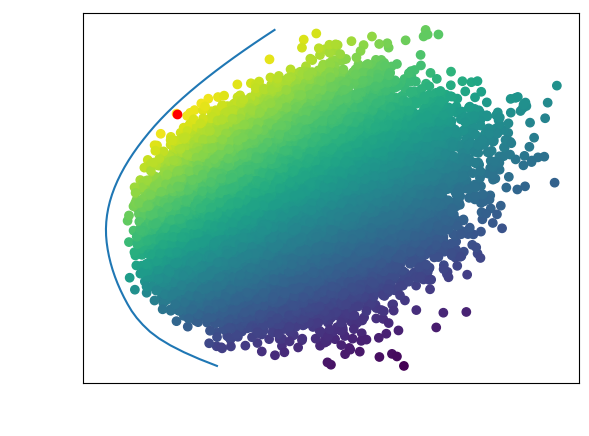

In [27]:
fig, ax = plt.subplots()

ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.scatter(tabela_volatilidades_esperadas[indice_do_sharpe_maximo],
          tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = 'red')
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis = 'x', colors = 'white')
ax.tick_params(axis = 'y', colors = 'white')

plt.show()